# Part 3.5 - Improvements

> See `part3_5_pipeline.py` for code to run the training.

We will try different transformers model architecture and training mode to find the best method for sentiment analysis:


| **Model**   | **Architecture**  | **Training Mode**                | **Description**                                                     |
|-------------|-------------------|----------------------------------|---------------------------------------------------------------------|
| **RoBERTa** | Encoder Only      | Pretrained                       | The original pretrained RoBERTa model, trained on a general corpus. |
|             |                   | Fine-Tuned on Sentiment Analysis | RoBERTa fine-tuned on sentiment analysis.                           |
| **GPT-2**   | Decoder Only      | Pretrained                       | The original pretrained GPT-2 model, trained on a general corpus.   |
|             |                   | Fine-Tuned on Sentiment Analysis | GPT-2 fine-tuned on sentiment analysis.                             |
| **T5**      | Encoder + Decoder | Pretrained                       | The original T5 model, trained on a general corpus.                 |



In [20]:
from utils.analytics import load_tensorboard_logs_from_huggingface_trainer

results_df = load_tensorboard_logs_from_huggingface_trainer("part3e_logs/")


# Test accuracy that was printed to the terminal:
test_accuracies = {
    "roberta": 0.8583489656448364,
    "roberta-finetuned": 0.8818011283874512,
    "gpt2-finetuned": 0.8536585569381714,
    "gpt2": 0.8508442640304565,
    "t5-small": 0.8424015045166016,
    "t5": 0.8827391862869263,
}


results_df["test_acc"] = results_df["model"].map(test_accuracies)
results_df = results_df[["model", "val_acc", "val_loss", "test_acc", "filename"]]
results_df = results_df.sort_values("val_acc", ascending=False).reset_index(drop=True)

results_df

,model,val_acc,val_loss,test_acc,filename
0,t5,0.909944,0.241378,0.882739,events.out.tfevents.1731063251.yuriarch.27786.0
1,roberta-finetuned,0.896811,0.282125,0.881801,events.out.tfevents.1731056602.yuriarch.20620.0
2,gpt2-finetuned,0.881801,0.332477,0.853659,events.out.tfevents.1730720697.yuriarch.3740.0
3,roberta,0.873358,0.341587,0.858349,events.out.tfevents.1730785167.yuriarch.1754.0
4,gpt2,0.866792,0.333615,0.850844,events.out.tfevents.1730824378.1e14d39e96a8.15...
5,t5-small,0.854597,0.361825,0.842402,events.out.tfevents.1730885598.776fcca9ca6f.65...


# Plots for Discussion

In [3]:
from models.RNN import RNNClassifier

num_parameters = {
    "t5-base": 223_495_682,
    "t5-small": 60_770_306,
    "roberta": 124_647_170,
    "gpt2": 124_441_344,
    "cnn": 4_980_802,  # based on our best cnn config
    "rnn": 4_934_090,  # based on our best rnn config
    "bilstm": 5_373_674,  # based on our best bilstm config
    "bigru": 5_373_674,  # based on our best bigru config TODO: change
}

test_acc = {
    "t5-base": 88.27,
    "t5-small": 84.24,
    "roberta": 88.18,
    "gpt2": 85.37,
    "cnn": 78.89,  # based on our best cnn config
    "rnn": 80.30,  # based on our best rnn config
    "bilstm": 78.33,  # based on our best bilstm config
    "bigru": 80.58,  # based on our best bigru config TODO: change
}

# model = RNNClassifier.load_from_checkpoint(
#     "tb_logs/bigru/batch_size_512-lr_0.0001-optimizer_Adam-hidden_dim_32-num_layers_1-sr_type_average-freeze_False-rnn_type_GRU-bidirectional_True/version_0/checkpoints/epoch=20-step=357.ckpt"
# )

# sum(p.numel() for p in model.parameters())

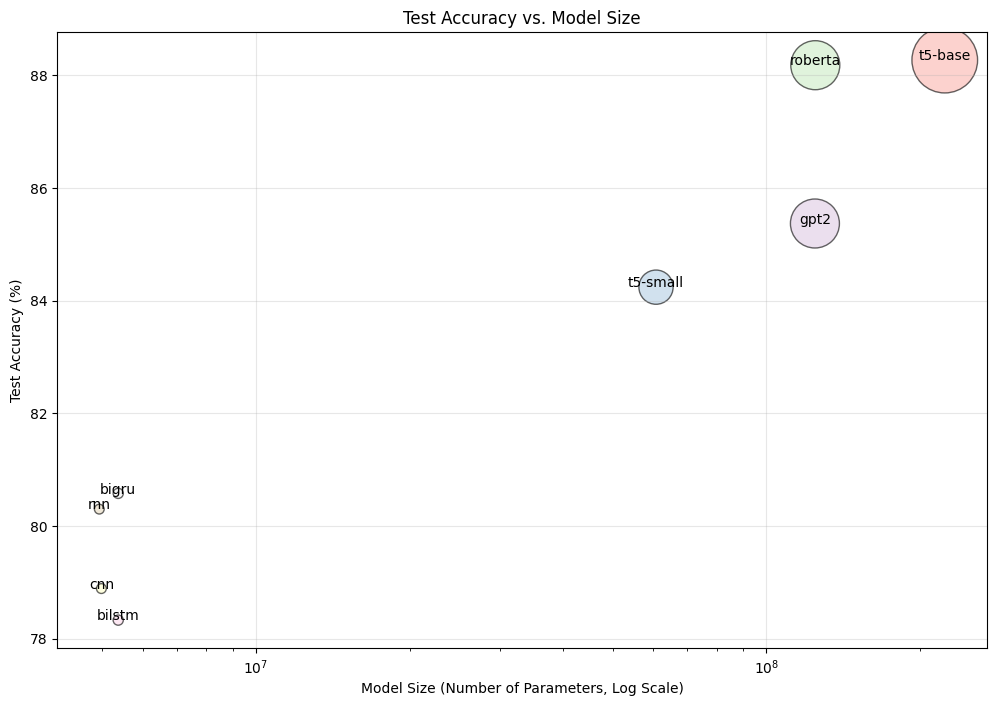

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
model_names = list(num_parameters.keys())
model_sizes = [num_parameters[model] for model in model_names]
test_accuracies = [test_acc[model] for model in model_names]

# Scale bubble sizes up for better visibility
bubble_sizes = [size / 100_000 for size in model_sizes]  # Increase scaling factor

# Use a pastel color map for better color differentiation
colors = plt.cm.Pastel1(np.linspace(0, 1, len(model_names)))

# Plot
plt.figure(figsize=(12, 8))
plt.scatter(
    model_sizes,
    test_accuracies,
    s=bubble_sizes,
    alpha=0.6,
    c=colors,
    edgecolors="k",
    linewidth=1,
)
plt.xscale("log")
plt.yscale("linear")
# plt.ylim(75, 100)

# Labeling the axes
plt.xlabel("Model Size (Number of Parameters, Log Scale)")
plt.ylabel("Test Accuracy (%)")
plt.title("Test Accuracy vs. Model Size")

# Annotate each point with model names
for i, model in enumerate(model_names):
    plt.annotate(
        model,
        (model_sizes[i], test_accuracies[i]),
        textcoords="offset points",
        xytext=(0, 0),
        ha="center",
    )

plt.grid(True, alpha=0.3)
plt.show()